In [1]:
# Import libraries
import pandas as pd
from datetime import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro, kruskal 
import scipy.stats as stats
import statistics as st

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [2]:
# Import and read the dataset
df = pd.read_csv("1A.tsv", sep = "\t")
df

,ID,Registration Date,Drug,Birth Date,Gender,Ascites,Hepatomegaly,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alkaline Phospatase (U/L),SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,2023/11/07,D-penicillamine,1966/03/07,F,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,Stage4
1,2,2012/08/16,D-penicillamine,1968/07/01,F,N,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,stage_3
2,3,2022/03/05,D-penicillamine,1954/11/15,M,N,N,S,1.4,NaN,3.48,210.0,516.0,96.10,55.0,151.0,12.0,Stage4
3,4,2019/09/04,D-penicillamine,1970/03/16,F,N,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,Stage4
4,5,2020/10/29,Placebo,1986/11/03,F,N,Y,N,3.4,NaN,3.53,143.0,671.0,113.15,72.0,136.0,10.9,stage_3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,414,2023/01/30,NaN,1957/12/11,F,NaN,NaN,N,1.2,NaN,2.96,NaN,NaN,NaN,-1.0,174.0,10.9,stage_3
414,415,2021/12/04,NaN,1985/12/11,F,NaN,NaN,N,0.9,NaN,3.83,NaN,NaN,NaN,-1.0,180.0,11.2,Stage4
415,416,2022/01/21,NaN,1967/12/12,F,NaN,NaN,N,1.6,NaN,3.42,NaN,NaN,NaN,-1.0,143.0,9.9,stage_3
416,417,2023/01/20,NaN,1966/12/11,F,NaN,NaN,N,0.8,NaN,3.75,NaN,NaN,NaN,-1.0,269.0,10.4,stage_3


## A. EDA

In [3]:
# Information of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ID                         418 non-null    int64  
 1   Registration Date          418 non-null    object 
 2   Drug                       312 non-null    object 
 3   Birth Date                 418 non-null    object 
 4   Gender                     418 non-null    object 
 5   Ascites                    312 non-null    object 
 6   Hepatomegaly               312 non-null    object 
 7   Edema                      418 non-null    object 
 8   Bilirubin                  418 non-null    float64
 9   Cholesterol                80 non-null     float64
 10  Albumin                    418 non-null    float64
 11  Copper                     310 non-null    float64
 12  Alkaline Phospatase (U/L)  312 non-null    float64
 13  SGOT                       312 non-null    float64

In [4]:
# Drop column ID 
print('Count of unique value in column ID:', len(pd.unique(df['ID'])))
df = df.drop('ID', axis=1)
df.head(3)

Count of unique value in column ID: 418


,Registration Date,Drug,Birth Date,Gender,Ascites,Hepatomegaly,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alkaline Phospatase (U/L),SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,2023/11/07,D-penicillamine,1966/03/07,F,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,Stage4
1,2012/08/16,D-penicillamine,1968/07/01,F,N,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,stage_3
2,2022/03/05,D-penicillamine,1954/11/15,M,N,N,S,1.4,NaN,3.48,210.0,516.0,96.10,55.0,151.0,12.0,Stage4


Column ID is an identifier (unique) so it does not give useful information to the model

In [5]:
# Drop column Registration Date
df = df.drop('Registration Date', axis=1)
df.head(3)

,Drug,Birth Date,Gender,Ascites,Hepatomegaly,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alkaline Phospatase (U/L),SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,D-penicillamine,1966/03/07,F,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,Stage4
1,D-penicillamine,1968/07/01,F,N,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,stage_3
2,D-penicillamine,1954/11/15,M,N,N,S,1.4,NaN,3.48,210.0,516.0,96.10,55.0,151.0,12.0,Stage4


In this case, Registration Date does not influence the medical or histologic stage of cirrhosis, it is not a relevant feature for modeling. So, it is dropped.

In [6]:
# Extract variable Age using birth date
# Typecasting column Birth Date to datetime format
df['Birth Date'] = pd.to_datetime(df['Birth Date'])

# Get the current date
current_date = datetime.now()

# Calculate age (based on current date)
df['Age'] = current_date.year - df['Birth Date'].dt.year

# Adjust for individuals whose birthdate hasn't occurred yet in the year
df['Age'] -= (current_date.month < df['Birth Date'].dt.month) | (
    (current_date.month == df['Birth Date'].dt.month) & 
    (current_date.day < df['Birth Date'].dt.day)
)

# Drop the Birth Date column because it is no longer needed
df.drop(columns=['Birth Date'], inplace=True)
df.head(3)

,Drug,Gender,Ascites,Hepatomegaly,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alkaline Phospatase (U/L),SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Age
0,D-penicillamine,F,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,Stage4,58
1,D-penicillamine,F,N,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,stage_3,56
2,D-penicillamine,M,N,N,S,1.4,NaN,3.48,210.0,516.0,96.10,55.0,151.0,12.0,Stage4,70


Using age rather than birth date is more meaningful because age provides a direct numerical value that reflects a patient’s current stage of life, which is often more relevant for predicting. 

In [7]:
# Column Tryglicerides contain value of -1 -> so it converted to become null value
print((df['Tryglicerides'] < 0).sum())
df['Tryglicerides'] = df['Tryglicerides'].apply(lambda x: np.nan if x < 0 else x)

136


There is 136 missing values in Tryglicerides

In [8]:
# Typecasting variable Stage
print(df['Stage'].unique())
df['Stage'].replace('Stage4',"4", inplace=True)
df['Stage'].replace('stage_3',"3", inplace=True)
df['Stage'].replace('Stage 2',"2", inplace=True)
df['Stage'].replace('Stage 1',"1", inplace=True)

print(df.info())
df.head(3)

['Stage4' 'stage_3' 'Stage 2' 'Stage 1' nan]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Drug                       312 non-null    object 
 1   Gender                     418 non-null    object 
 2   Ascites                    312 non-null    object 
 3   Hepatomegaly               312 non-null    object 
 4   Edema                      418 non-null    object 
 5   Bilirubin                  418 non-null    float64
 6   Cholesterol                80 non-null     float64
 7   Albumin                    418 non-null    float64
 8   Copper                     310 non-null    float64
 9   Alkaline Phospatase (U/L)  312 non-null    float64
 10  SGOT                       312 non-null    float64
 11  Tryglicerides              282 non-null    float64
 12  Platelets                  407 non-null    float64
 13  Proth

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_22228\2615385630.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Stage'].replace('Stage4',"4", inplace=True)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_22228\2615385630.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For ex

,Drug,Gender,Ascites,Hepatomegaly,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alkaline Phospatase (U/L),SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Age
0,D-penicillamine,F,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4,58
1,D-penicillamine,F,N,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3,56
2,D-penicillamine,M,N,N,S,1.4,NaN,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4,70


In [9]:
# Correct the value of variable Drug because it should only be D-penicillamine or placebo 
print(df['Drug'].unique())
df['Drug'].replace('d-penicillamine', "D-penicillamine", inplace=True)
df['Drug'].replace('Placebo', "placebo", inplace=True)
df['Drug'].replace('lacebo', "placebo", inplace=True)

['D-penicillamine' 'Placebo' 'placebo' 'lacebo' 'd-penicillamine' nan]


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_22228\4112061544.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Drug'].replace('d-penicillamine', "D-penicillamine", inplace=True)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_22228\4112061544.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always beh

There are some inconsistencies in some values of the Drug variable. According to the question guide, there are only 2 drugs, namely  D-penicillamine and placebo

In [10]:
# Check duplicate rows
df.duplicated().sum()

np.int64(0)

There is no duplicated rows

In [11]:
# Check missing values
print(df.shape)
print(df.isna().sum())

(418, 16)
Drug                         106
Gender                         0
Ascites                      106
Hepatomegaly                 106
Edema                          0
Bilirubin                      0
Cholesterol                  338
Albumin                        0
Copper                       108
Alkaline Phospatase (U/L)    106
SGOT                         106
Tryglicerides                136
Platelets                     11
Prothrombin                    2
Stage                          6
Age                            0
dtype: int64


There is 418 rows of data with 16 columns.\
There are 11 columns with missing values: Drug, Ascites, Hepatomegaly, Cholesterol, Alkaline Phospatase, SGOT, Copper, Prothrombin, Tryglicerides, Stage, Platelets.

In [12]:
# Drop column Cholesterol 
df = df.drop(['Cholesterol'], axis=1)

print(df.shape)
print(df.isna().sum())

(418, 15)
Drug                         106
Gender                         0
Ascites                      106
Hepatomegaly                 106
Edema                          0
Bilirubin                      0
Albumin                        0
Copper                       108
Alkaline Phospatase (U/L)    106
SGOT                         106
Tryglicerides                136
Platelets                     11
Prothrombin                    2
Stage                          6
Age                            0
dtype: int64


Column Cholesterol is dropped (by column) because the missing values is very large with more than 80% (338 from 418) . If it is just dropped by row, the remaining data is too small. 

In [13]:
# Drop missing values in Stage
df = df.dropna(subset='Stage').reset_index(drop=True)

# Typecast Stage into integer for EDA & later we do not need encoding
df['Stage'] = df['Stage'].astype(int)

print(df.shape)
print(df.isna().sum())

(412, 15)
Drug                         100
Gender                         0
Ascites                      100
Hepatomegaly                 100
Edema                          0
Bilirubin                      0
Albumin                        0
Copper                       102
Alkaline Phospatase (U/L)    100
SGOT                         100
Tryglicerides                130
Platelets                     11
Prothrombin                    2
Stage                          0
Age                            0
dtype: int64


Missing values in Stage are dropped to avoid bias and misclassify if we imputed.

In [14]:
# Separate the numerical and categorical columns
num_cols = []
cat_cols = []

for i in df.columns:
    if('int' in str(df[i].dtype) or 'float' in str(df[i].dtype)):
        num_cols.append(i)
    else:
        cat_cols.append(i)

print(f'Numerical Column: {num_cols}')
print(f'Categorical Column: {cat_cols}')

Numerical Column: ['Bilirubin', 'Albumin', 'Copper', 'Alkaline Phospatase (U/L)', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage', 'Age']
Categorical Column: ['Drug', 'Gender', 'Ascites', 'Hepatomegaly', 'Edema']


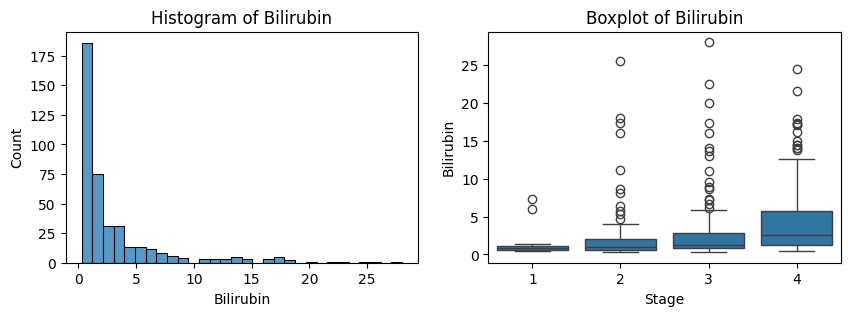

Skewness of Bilirubin: 2.7114832786508076
Kurtosis of Bilirubin: 7.98910224587442


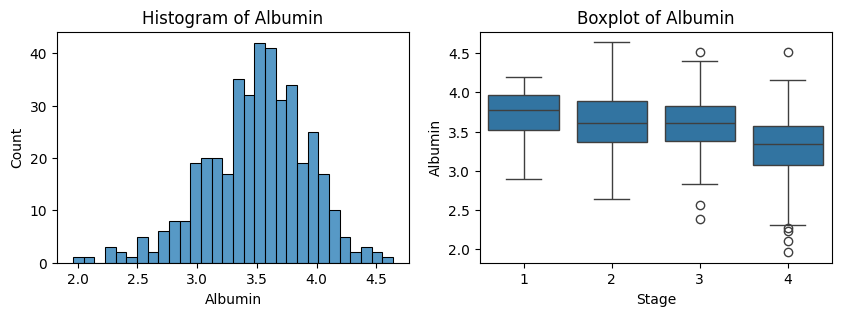

Skewness of Albumin: -0.4573286868031913
Kurtosis of Albumin: 0.576119970281622


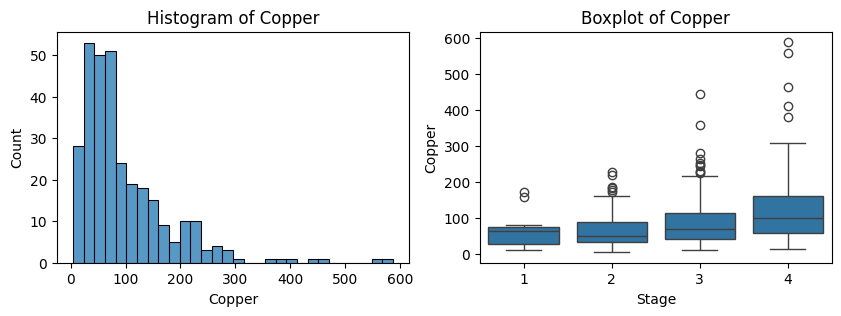

Skewness of Copper: 2.3036399957832625
Kurtosis of Copper: 7.624023449861706


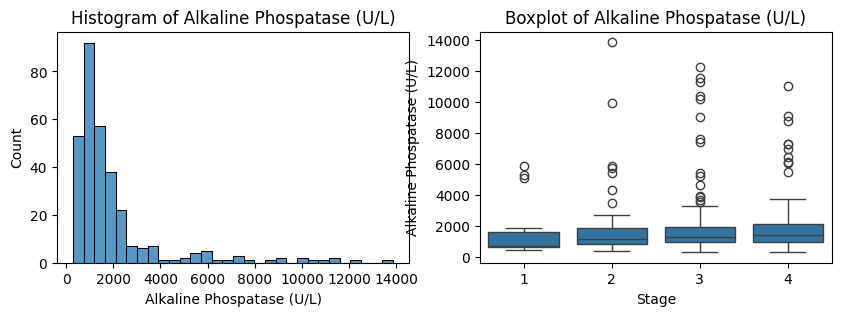

Skewness of Alkaline Phospatase (U/L): 2.992834315349611
Kurtosis of Alkaline Phospatase (U/L): 9.66255346096615


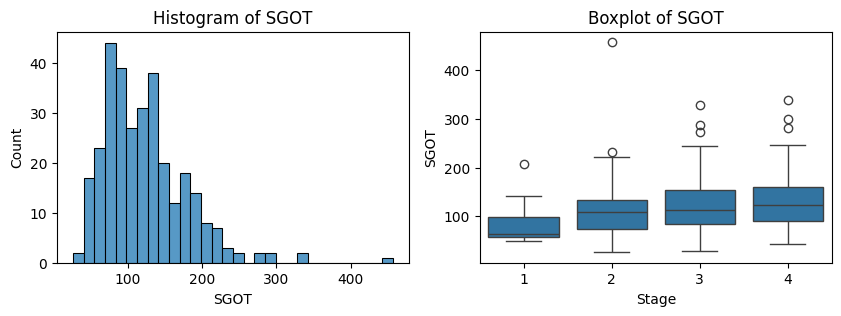

Skewness of SGOT: 1.4491969235882083
Kurtosis of SGOT: 4.3119758576052165


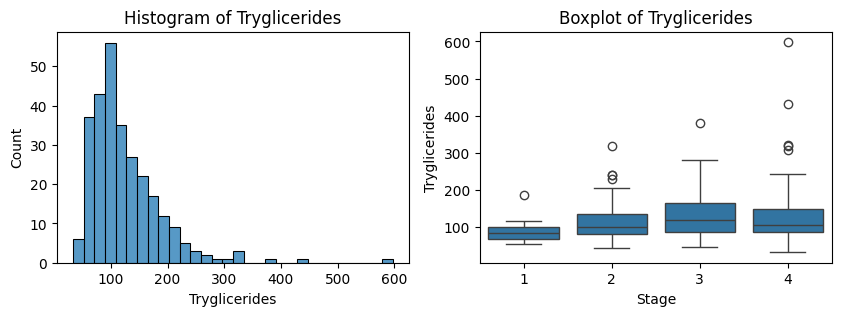

Skewness of Tryglicerides: 2.5239024664577845
Kurtosis of Tryglicerides: 11.802753128498214


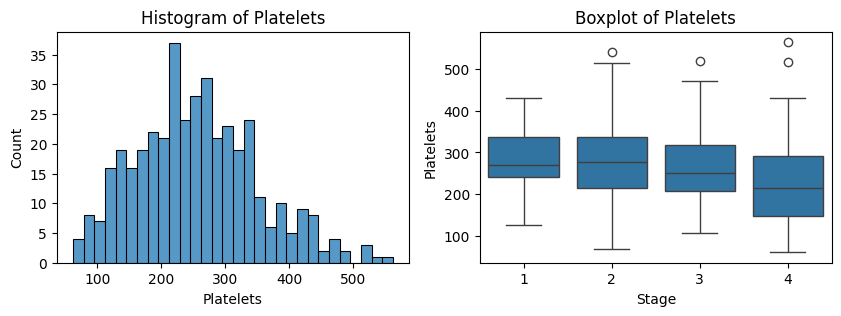

Skewness of Platelets: 0.43656837006514054
Kurtosis of Platelets: -0.03693723756606904


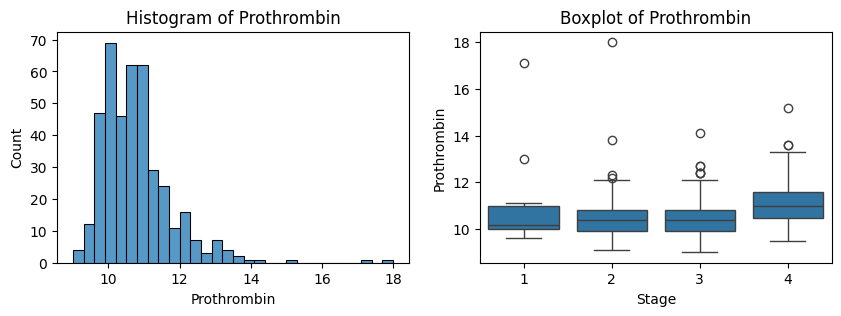

Skewness of Prothrombin: 2.220273877768083
Kurtosis of Prothrombin: 9.982101332311563


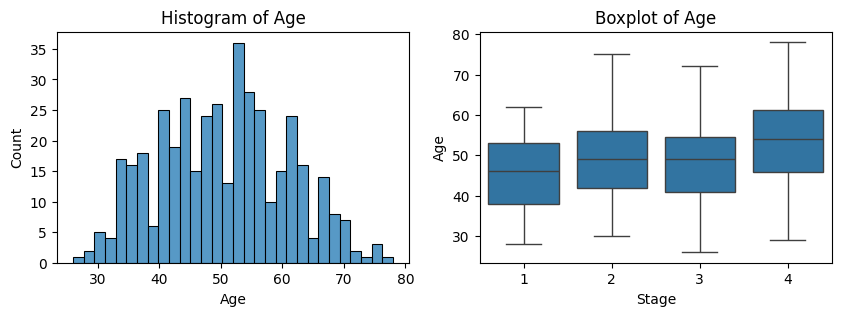

Skewness of Age: 0.09977496163732234
Kurtosis of Age: -0.6106813112051803


In [15]:
# Check the distribution and outliers of numerical columns
def check_distribution(df, columns):
    for i in columns:
        if (i == 'Stage'): continue
        plt.figure(figsize=(10,3))

        # histogram
        plt.subplot(1,2,1)
        sns.histplot(df[i], bins=30)
        plt.title(f'Histogram of {i}')

        # boxplot
        plt.subplot(1,2,2)
        sns.boxplot(x='Stage', y=df[i], data=df)
        plt.title(f'Boxplot of {i}')

        plt.show()

        print(f'Skewness of {i}:', df[i].skew())
        print(f'Kurtosis of {i}:', df[i].kurt())

check_distribution(df[num_cols], num_cols)

There are outliers in all numerical variables, except in variable Age. The outliers represent genuine variations in the data and can provide valuable insights so outliers are not removed.

In [16]:
# Imputation using median because there are outliers in the variables
print("Median of Tryglicerides: ", df['Tryglicerides'].median())
df['Tryglicerides'].fillna(df['Tryglicerides'].median(), inplace=True)

print("Median of Copper: ", df['Copper'].median())
df['Copper'].fillna(df['Copper'].median(), inplace=True)

print("Median of Alkaline Phospatase: ", df['Alkaline Phospatase (U/L)'].median())
df['Alkaline Phospatase (U/L)'].fillna(df['Alkaline Phospatase (U/L)'].median(), inplace=True)

print("Median of SGOT: ", df['SGOT'].median())
df['SGOT'].fillna(df['SGOT'].median(), inplace=True)

print("Median of Platelets: ", df['Platelets'].median())
df['Platelets'].fillna(df['Platelets'].median(), inplace=True)

print("Median of Prothrombin: ", df['Prothrombin'].median())
df['Prothrombin'].fillna(df['Prothrombin'].median(), inplace=True)

Median of Tryglicerides:  108.0
Median of Copper:  73.0
Median of Alkaline Phospatase:  1259.0
Median of SGOT:  114.7
Median of Platelets:  249.0
Median of Prothrombin:  10.6


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_22228\2635187501.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Tryglicerides'].fillna(df['Tryglicerides'].median(), inplace=True)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_22228\2635187501.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always beh

In [17]:
# Imputation using mode
print("Mode of Drug:", st.mode(df['Drug']))
df['Drug'].fillna(st.mode(df['Drug']), inplace=True)

print("Mode of Ascites:", st.mode(df['Ascites']))
df['Ascites'].fillna(st.mode(df['Ascites']), inplace=True)

print("Mode of Hepatomegaly:", st.mode(df['Hepatomegaly']))
df['Hepatomegaly'].fillna(st.mode(df['Hepatomegaly']), inplace=True)

Mode of Drug: D-penicillamine
Mode of Ascites: N
Mode of Hepatomegaly: Y


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_22228\1806596568.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Drug'].fillna(st.mode(df['Drug']), inplace=True)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_22228\1806596568.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

F

- Column Tryglicerides and Copper has missing values more than 31% (130 from 412) and 25% (102 from 412) -> it will be imputed using median
- Column Alkaline Phospatase and SGOT have missing values more than 25% (100 from 412) -> it will be imputed using median
- Column Drug, Ascites, and Hepatomegaly have missing values more than 25% (100 from 412) -> it will be imputed using mode
- Column Platelets and Prothrombin have small missing values -> it will be imputed using median
- Eventhough it can cause bias, I choose to impute because the dataset is very small, so dropping can remove variation in the dataset.

In [18]:
# Check missing values
print(df.shape)
print(df.isna().sum())

(412, 15)
Drug                         0
Gender                       0
Ascites                      0
Hepatomegaly                 0
Edema                        0
Bilirubin                    0
Albumin                      0
Copper                       0
Alkaline Phospatase (U/L)    0
SGOT                         0
Tryglicerides                0
Platelets                    0
Prothrombin                  0
Stage                        0
Age                          0
dtype: int64


After handling the missing values, there is 412 rows of data remaining with 15 columns.

In [19]:
# Check the unique values and the count of it from categorical columns
print(df['Stage'].value_counts(), "\n")
for i in cat_cols:
    print(df[i].value_counts(), "\n")

Stage
3    155
4    144
2     92
1     21
Name: count, dtype: int64 

Drug
D-penicillamine    258
placebo            154
Name: count, dtype: int64 

Gender
F    368
M     44
Name: count, dtype: int64 

Ascites
N    388
Y     24
Name: count, dtype: int64 

Hepatomegaly
Y    260
N    152
Name: count, dtype: int64 

Edema
N    348
S     44
Y     20
Name: count, dtype: int64 



The dataset has imbalanced distribution in target variable. Stage 3 and 4 are the most common stages. While, stage 1 is underrepresented.

In [20]:
df[num_cols].describe()

,Bilirubin,Albumin,Copper,Alkaline Phospatase (U/L),SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Age
count,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000
mean,3.227670,3.500073,91.546117,1807.011165,120.649466,119.432039,255.912621,10.732767,3.024272,50.347087
std,4.429421,0.423948,74.994211,1887.615128,49.436930,54.426519,94.467529,1.024098,0.882042,10.500998
min,0.300000,1.960000,4.000000,289.000000,26.350000,33.000000,62.000000,9.000000,1.000000,26.000000
25%,0.800000,3.247500,51.000000,1009.000000,90.725000,94.000000,190.000000,10.000000,2.000000,42.000000
50%,1.400000,3.530000,73.000000,1259.000000,114.700000,108.000000,249.000000,10.600000,3.000000,51.000000
75%,3.400000,3.782500,102.000000,1716.500000,136.485000,128.500000,314.500000,11.100000,4.000000,58.000000
max,28.000000,4.640000,588.000000,13862.400000,457.250000,598.000000,563.000000,18.000000,4.000000,78.000000


In [21]:
# Check the normality of the distribution of the numerical columns
for i in num_cols:
    if (i == 'Stage'): continue
    print(i, shapiro(df[i]))

Bilirubin ShapiroResult(statistic=np.float64(0.6310120504894303), pvalue=np.float64(8.454908561498212e-29))
Albumin ShapiroResult(statistic=np.float64(0.9871335612721758), pvalue=np.float64(0.0010470723311495447))
Copper ShapiroResult(statistic=np.float64(0.7285479537706353), pvalue=np.float64(2.2786042232922965e-25))
Alkaline Phospatase (U/L) ShapiroResult(statistic=np.float64(0.5457952970063356), pvalue=np.float64(2.9802442864138016e-31))
SGOT ShapiroResult(statistic=np.float64(0.8779772837853816), pvalue=np.float64(1.6325612305245782e-17))
Tryglicerides ShapiroResult(statistic=np.float64(0.7362625856702114), pvalue=np.float64(4.656225625342208e-25))
Platelets ShapiroResult(statistic=np.float64(0.9841404845893832), pvalue=np.float64(0.00017519146631892417))
Prothrombin ShapiroResult(statistic=np.float64(0.8488869234518106), pvalue=np.float64(1.8405970687507553e-19))
Age ShapiroResult(statistic=np.float64(0.9898330932013056), pvalue=np.float64(0.005943973870447081))


All variables are not normally distributed because all the p-values are less than 0.05. Hence, we will use Kruskal-Wallis test.\
The Kruskal-Wallis test is used to determine if there are statistically significant differences in the distributions of a numerical variable across multiple groups of stage. 

Later, we will also use Robust Scaler for scaling.

In [22]:
# Perform Kruskal-Wallis test
stage_column = 'Stage' 
numerical_columns = ['Bilirubin', 'Albumin', 'Copper', 'Alkaline Phospatase (U/L)', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Age']  

# Kruskal-Wallis test
results = {}
for col in numerical_columns:
    # Group data by stage
    grouped = [df[df[stage_column] == stage][col] for stage in df[stage_column].unique()]
    
    # Perform Kruskal-Wallis test
    stat, p_value = kruskal(*grouped)
    results[col] = {'statistic': stat, 'p-value': p_value}
    
# Display results
for col, result in results.items():
    print(f'{col} - statistic={result['statistic']} | p-value={result['p-value']}')

Bilirubin - statistic=46.63801517132148 | p-value=4.1497626260901583e-10
Albumin - statistic=48.51261056837618 | p-value=1.6564500995203657e-10
Copper - statistic=24.881118312993 | p-value=1.634991559554988e-05
Alkaline Phospatase (U/L) - statistic=6.87398504851217 | p-value=0.07602462170574184
SGOT - statistic=14.114126536769502 | p-value=0.0027538517946786504
Tryglicerides - statistic=11.346741880667594 | p-value=0.009991337290372524
Platelets - statistic=27.235252513835007 | p-value=5.255258204227018e-06
Prothrombin - statistic=52.483699912354716 | p-value=2.362174668002248e-11
Age - statistic=20.235546853080077 | p-value=0.00015169216423836706


If p-value < 0.05, it indicates that there is a statistically significant difference in the distributions of the numerical variable across the different stages of cirrhosis. This suggests that the numerical variables differ in a meaningful way as the cirrhosis stage progresses.

Bilirubin, Albumin, Prothrombin, Platelets, Copper, and Age have strong relationships with stage, making them highly relevant for modeling. SGOT and Tryglicerides have low to moderate relevance to stage prediction. While, Alkaline Phospatase does not show significant difference across the different stages of cirrhosis.

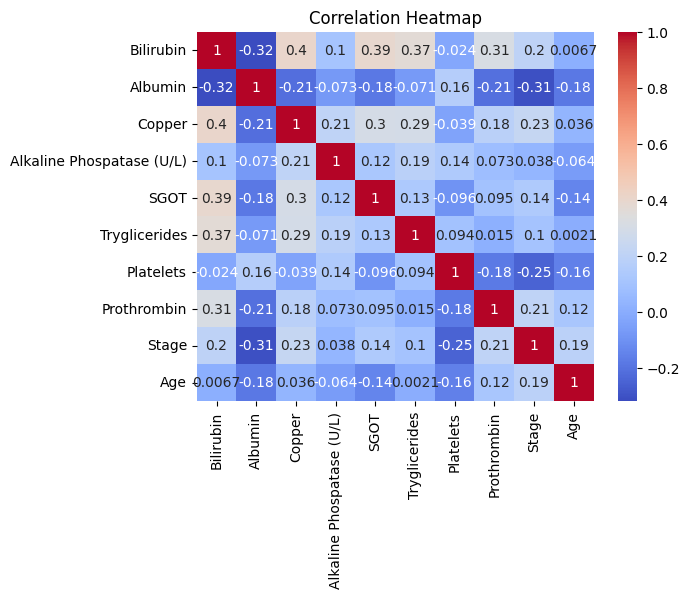

In [23]:
# Correlation between numerical columns
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

The correlations between the numerical variables (Copper, Prothrombin, Bilirubin, and Age) and Stage show weak positive correlations, suggesting that these variables tend to increase as the stage progresses. In contrast, Albumin and Platelets show weak negative correlations with Stage, indicating that as the stage advances, these variables tend to decrease.

### Summary of EDA
- Dataset has total 418 rows of data and 18 columns, with 1 identifier column (ID) that dropped. 
- Registration Date column is dropped because it doesn't provide meaningful insight for predicting stage of cirrhosis.
- Age column is made from Birth Date column because Age is more informative for this case. 
- There are value of -1 in Tryglicerides that considered as null values.
- The value in some variables are not correct (it will affect the unique value), such as in Stage and Drug. So, I perform a correction using replace.
- There is no duplicated rows.
- There are 11 columns with missing values: Drug, Ascites, Hepatomegaly, Cholesterol, Alkaline Phospatase, SGOT, Copper, Tryglicerides, Prothrombin, Stage, Platelets. Cholesterol is dropped by column because the number of missing values is very large (80%). While, missing values in Stage are also dropped. It is to avoid using too much synthetic data so that it can minimize bias in medical case. 
- Missing values in Alkaline Phospatase, SGOT, Copper, Tryglicerides, Prothrombin, and Platelets  are imputed using median because it has outliers. While, missing values in Drug, Ascites, Hepatomegaly are imputed using mode. Imputation is chosen because the dataset is small and dropping can remove variation in the dataset.
- After handling the missing values, there is 412 rows of data and 15 columns left.
- 14 columns are predictors, while 1 column is target variable (Stage column).
- There are 9 numerical variables and 6 categorical variables, include Stage.
- Variabel Stage has 4 class: stage 1 has 12 data, stage 2 has 59 data, stage 3 has 111 data, and stage 4 has 94 data. This shows that the data is imbalanced (stage 1 is underrepresented).
- There are outliers in all numerical columns. Outliers represent genuine variations in the data and can provide valuable insights so outliers are not removed.
- From Shapiro test, all numerical variables are not normally distributed.
- From Kruskal-Wallis test, Bilirubin, Albumin, Prothrombin, Platelets, Copper, and Age shows strong relationships with stage, making them highly relevant for modeling. SGOT and Tryglicerides have low to moderate relevance to stage prediction. While, Alkaline Phospatase does not show significant difference across the different stages of cirrhosis.
- Copper, Prothrombin, Bilirubin, and Age show weak positive correlations with Stage. While, Albumin and Platelets show weak negative correlations with Stage. Other variables show very small correlation.

### Data Pre-Processing

In [24]:
# Encode the categorical columns using label encoder
label_enc = LabelEncoder()
label_col = ['Drug', 'Gender', 'Ascites', 'Hepatomegaly']

df = df.reset_index(drop=True)
for i in label_col:
    df[i] = label_enc.fit_transform(df[[i]].values)

c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_lab

Some categorical variables like Drug (D-penicillamine or placebo), Gender (F or M), Ascites (Y or N), and Hepatomegaly ((Y or N)) are binary. So, the encoding will be performed using Label Encoder.

In [25]:
# Encode categorical columns using ordinal encoder
ord_enc = OrdinalEncoder(categories=[['N','S','Y']]) 
df['Edema'] = ord_enc.fit_transform(df[['Edema']])

Edema values show an order, where N (no edema) < S (edema without diuretics) < Y (edema despite diuretics), so it will be encoded using Ordinal Encoder.

In [26]:
# Split the data
x = df[df.columns.drop(['Stage'])]
y = df['Stage']
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=42)

In [27]:
# Scaling
robust_scale = RobustScaler()
robust_col = ['Bilirubin', 'Albumin', 'Copper', 'Alkaline Phospatase (U/L)', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Age']

xtrain[robust_col] = robust_scale.fit_transform(xtrain[robust_col])
xtest[robust_col] = robust_scale.transform(xtest[robust_col])

The scale process uses Robust Scaler because all the numerical variables are not normally distributed.

## B. Train, Fine-Tune, and Evaluate Random Forest & XGBoost Model

### Train Random Forest Model

In [28]:
# Create a model using the random forest algorithm
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 42)  
rf_model.fit(xtrain, ytrain)
ypred_rf = rf_model.predict(xtest)

### Evaluate Random Forest Model

Random Forest Accuracy Score: 0.4939759036144578
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         6
           2       0.15      0.11      0.13        18
           3       0.47      0.75      0.58        28
           4       0.72      0.58      0.64        31

    accuracy                           0.49        83
   macro avg       0.34      0.36      0.34        83
weighted avg       0.46      0.49      0.46        83



c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

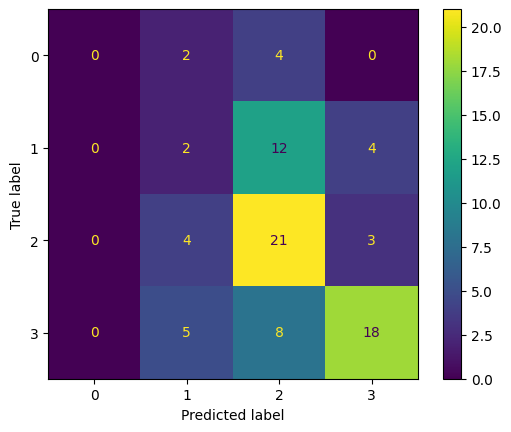

In [29]:
# Evaluate the model
# Accuracy
print("Random Forest Accuracy Score:", accuracy_score(ytest, ypred_rf))

# Classification report
print(classification_report(ytest, ypred_rf))

# Confusion matrix
cm_rf = confusion_matrix(ytest, ypred_rf)
display_rf = ConfusionMatrixDisplay(cm_rf)
display_rf.plot()
plt.show()

The metric that very important in this case is F1-score weighted. It computes the F1 score for each class and takes the weighted mean, where the weights are based on the number of true instances (support) for each class. F1-score ensures that both precision and recall are balanced, making it particularly important in medical datasets where both false positives and false negatives have significant implications (misclassifications can have serious consequences). A higher F1-score for all stages indicates that the model is reliable for predicting cirrhosis stages accurately. 

- Stage 1: All the precision, recall, and F1-score are 0. It means the model fails to predict class 1 correctly. This is likely due to the very low frequency of this class in the dataset (only 6 sample), making it extremely difficult for the model to learn its characteristics.
- Stage 2: Class 2 also faces poor performance (F1-score 0.13). Precision 0.15 means that a significant portion of the predictions for Class 2 were false positives, where non-Class 2 instances were incorrectly classified as Class 2.Recall 0.11 shows that the model was unable to capture most of the true Class 2 instances. Despite having more instances than Class 1, it still struggles to predict this class effectively, likely due to its imbalance in the dataset. 
- Stage 3: Class 3 shows a slightly better performance compared to the previous classes, likely due to larger support (more instances). The precision 0.47 indicates that there were still a significant number of false positives. The recall 0.75 is relatively high and suggests that the model was better at detecting Class 3 instances compared to the other classes.
- Stage 4: High precision (0.72) but moderate recall (0.58). This suggests that the model was good at classifying Class 4 instances with fewer false positives. While this recall is decent, it leaves room for improvement in identifying more true Class 4 instances.
- Weighted average F1-score of 0.46 suggests that the model is struggling with the class imbalance. A 0.46 score indicates that while the model might be performing better on some classes, it is failing to properly classify the minority classes, which could be skewing the overall performance.

### Oversampling

In [30]:
# Initialize the oversampler
smote = SMOTE(random_state=42)
xtrainSmote = xtrain
ytrainSmote = ytrain

# Apply oversampling to the training set
xtrainSmote, ytrainSmote = smote.fit_resample(xtrainSmote, ytrainSmote)

### Fine-Tuning for Random Forest Model Using Oversampling

In [31]:
parameter_rf = {
    'n_estimators': [100, 200, 500], 
    'max_depth': [3, 10, None], 
    'max_features': [None, 'sqrt', 'log2'], 
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'class_weight': ['balanced', 'balanced_subsample', {1:6, 2:18, 3:28, 4:31}]
}

In [32]:
# Create the GridSearchCV object
gridsearch_rf = GridSearchCV(estimator=rf_model, 
                            param_grid=parameter_rf, 
                            scoring='f1_weighted', # how the model performance will be evaluated
                            cv=5, # cross validation splitting strategy
                            verbose=2, # controls the amount of output printed to the console
                            n_jobs=-1) # number of CPU cores to use for parallel processing

# Do the fitting process
gridsearch_rf.fit(xtrainSmote, ytrainSmote)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': ['balanced', 'balanced_subsample',
                                          {1: 6, 2: 18, 3: 28, 4: 31}],
                         'max_depth': [3, 10, None],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 500]},
             scoring='f1_weighted', verbose=2)

In [33]:
# Best parameters
bestparams_rf = gridsearch_rf.best_params_
print(f"Best parameters: {bestparams_rf}")

Best parameters: {'class_weight': {1: 6, 2: 18, 3: 28, 4: 31}, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}


In [34]:
# Predictions on the test set
bestestimator_rf = gridsearch_rf.best_estimator_
ypred_rf2 = bestestimator_rf.predict(xtest)

Random Forest Accuracy Score After Grid Search CV: 0.46987951807228917
              precision    recall  f1-score   support

           1       0.40      0.33      0.36         6
           2       0.19      0.22      0.21        18
           3       0.52      0.54      0.53        28
           4       0.64      0.58      0.61        31

    accuracy                           0.47        83
   macro avg       0.44      0.42      0.43        83
weighted avg       0.48      0.47      0.48        83



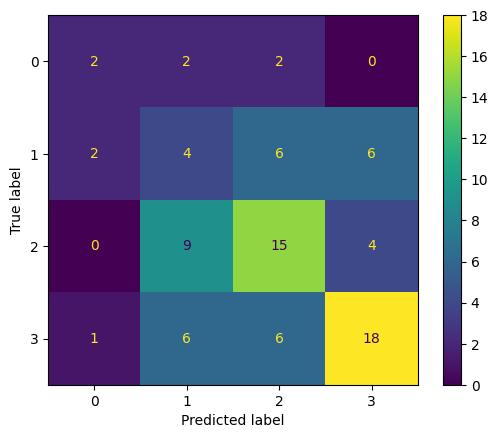

In [35]:
# Evaluate Random Forest model after fine-tuning
# Accuracy
print("Random Forest Accuracy Score After Grid Search CV:", accuracy_score(ytest, ypred_rf2))

# Classification report 
print(classification_report(ytest, ypred_rf2))

# Confusion matrix
cm_rf2 = confusion_matrix(ytest, ypred_rf2)
display_rf2 = ConfusionMatrixDisplay(cm_rf2)
display_rf2.plot()
plt.show()

- Stage 1: The precision for Class 1 improved to 0.40, meaning that 40% of the predictions for Class 1 were correct. This indicates a significant improvement in the model's ability to correctly identify Class 1 instances. Recall for Class 1 increased to 0.33, meaning the model now identified 33% of the true Class 1 instances, reflecting substantial improvement. The F1-score for Class 1 increased to 0.36, but the overall performance is still limited by the class imbalance.
- Stage 2: The precision for Class 2 increased to 0.19, indicating that 19% of the predictions for Class 2 were correct. This reflects some improvement in the model's ability to classify Class 2 instances, though much improvement is still needed. Recall improved to 0.22, meaning the model now identified 22% of the true Class 2 instances. While this is still low, the model has improved its ability to detect Class 2 instances. The F1-score for Class 2 increased to 0.21. Although the F1-score is still low, the improvement shows progress in addressing class imbalance.
- Stage 3: Although the precision for Class 3 slightly improved to 0.52, the recall for Class 3 decreased to 0.54. This decline may be a trade-off resulting from adjustments made to balance the performance across all classes. 
- Stage 4: The precision for Class 4 slightly decreased to 0.64, meaning the accuracy of predicting Class 4 instances dropped slightly. Recall for Class 4 remained the same (0.58).
- Weighted average F1-score increases (0.48). It indicates that resampling and tuning boost the performance in balancing the precision and recall among all classes.

### Train XGBoost Model

In [36]:
# Create a model using XGBoost
# Class in XGBoost should be from 0
ytrain_xgb = ytrain - 1
ytest_xgb = ytest - 1
xgb_model = xgb.XGBClassifier(
                            n_estimators = 100,
                            learning_rate=0.3, 
                            random_state=42)

xgb_model.fit(xtrain, ytrain_xgb)
ypred_xgb = xgb_model.predict(xtest)

### Evaluate XGBoost Model

XGBoost Accuracy Score: 0.4578313253012048
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.19      0.22      0.21        18
           2       0.45      0.46      0.46        28
           3       0.64      0.68      0.66        31

    accuracy                           0.46        83
   macro avg       0.32      0.34      0.33        83
weighted avg       0.43      0.46      0.44        83



c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

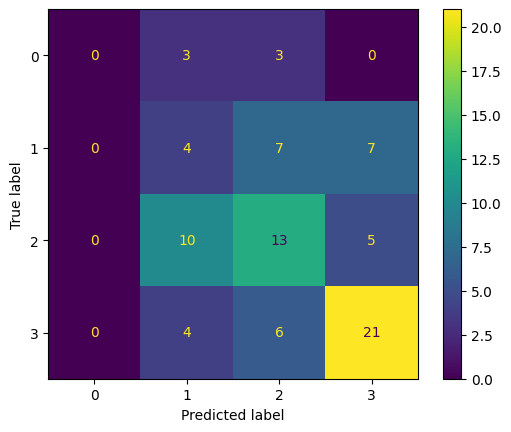

In [37]:
# Evaluate the model
# Accuracy
print("XGBoost Accuracy Score:", accuracy_score(ytest_xgb, ypred_xgb))

# Classification report
print(classification_report(ytest_xgb, ypred_xgb))

# Confusion matrix
cm_xgb = confusion_matrix(ytest_xgb, ypred_xgb)
disp_xgb = ConfusionMatrixDisplay(cm_xgb)
disp_xgb.plot()
plt.show()

- Stage 1: Precision, recall, and F1-score are 0, indicating that the model misses this class completely. The low frequency of Class 1 in the dataset contributes to its inability to be correctly identified by the model.
- Stage 2: Class 2 had low performance, with precision, recall, and F1-score below 0.25.
- Stage 3: Class 3 had relatively balanced performance, with precision, recall, and F1-score around 0.45, which indicates an acceptable but not outstanding classification performance.
- Stage 4: Class 4 had the best performance, with a precision of 0.64 and recall of 0.68, leading to an F1-score of 0.66. It reflects the model's relatively better ability to identify Class 4, with fewer false positives and false negatives compared to other classes.
- The weighted average F1-score 0.44, suggesting that the model is not performing optimally in balancing precision and recall. While it may be doing okay in some classes, the overall performance is held back by weaker performance in certain classes (class 1 and 2).

### Fine-Tuning for XGBoost Model Using Oversampling

In [38]:
# Ytrain for XGBoost after oversampling
ytrainSmote_xgb = ytrainSmote - 1

# Define the parameters for grifine-tuning the XGBoost model 
parameter_xgb = {
    'max_depth': [3, 7, 10],
    'subsample': [0.6, 0.8, 1],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [200, 500, 1000],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

In [39]:
# Create the GridSearchCV object
gridsearch_xgb = GridSearchCV(estimator=xgb_model, 
                            param_grid=parameter_xgb, 
                            scoring='f1_weighted', # how the model performance will be evaluated
                            cv=5, # cross validation splitting strategy
                            verbose=2, # controls the amount of output printed to the console
                            n_jobs=-1) # number of CPU cores to use for parallel processing

# Do the fitting process
gridsearch_xgb.fit(xtrainSmote, ytrainSmote_xgb)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.3, m...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=100,
                                     n_jobs=None, num_parallel_tree=None,
                                     objective='multi:softprob', ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [3, 7, 10],
                         'n_estimators': [200, 500, 1000],
                         'subsample': [0.6, 0.8, 1]},
             scoring='f1_weighted', verbose=2)

In [40]:
# Best parameters
bestparams_xgb = gridsearch_xgb.best_params_
print(f"Best parameters: {bestparams_xgb}")

Best parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500, 'subsample': 1}


In [41]:
# Predictions on the test set
bestestimator_xgb = gridsearch_xgb.best_estimator_
ypred_xgb2 = bestestimator_xgb.predict(xtest)

XGBoost Accuracy Score After Grid Search CV: 0.40963855421686746
              precision    recall  f1-score   support

           0       1.00      0.17      0.29         6
           1       0.16      0.22      0.19        18
           2       0.40      0.43      0.41        28
           3       0.63      0.55      0.59        31

    accuracy                           0.41        83
   macro avg       0.55      0.34      0.37        83
weighted avg       0.48      0.41      0.42        83



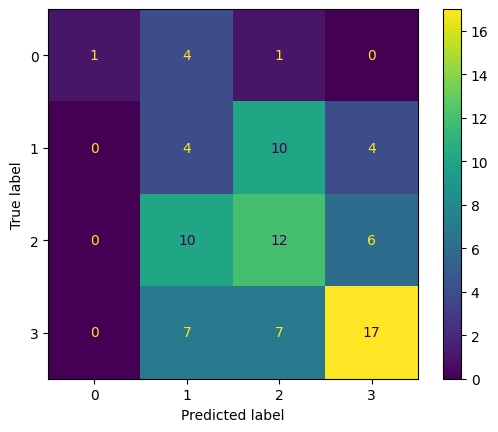

In [42]:
# Evaluate the XGBoost model after fine-tuning
# Accuracy
print("XGBoost Accuracy Score After Grid Search CV:", accuracy_score(ytest_xgb, ypred_xgb2))

# Classification report
print(classification_report(ytest_xgb, ypred_xgb2))

# Confusion matrix
cm_xgb2 = confusion_matrix(ytest_xgb, ypred_xgb2)
disp_xgb2 = ConfusionMatrixDisplay(cm_xgb2)
disp_xgb2.plot()
plt.show()

- Stage 1: Class 1 shows a dramatic improvement in precision (from 0.00 to 1.00), indicating that all predictions for Class 1 are now correct. However, recall remains low (0.17), meaning only a small fraction of actual Class 1 instances are identified. This suggests that the model is still struggling with recall for this class despite the oversampling.
- Stage 2: Precision decreased slightly from 0.19 to 0.16. While recall remains the same at 0.22. The F1-score decreased slightly to 0.19, indicating Class 2 is still underperforming.
- Stage 3: Precision, recall, and F1-score slightly decreased, indicating that Class 3 performance was largely unaffected by the oversampling and tuning.
- Stage 4: recision, recall, and F1-score slightly decreased. It means that oversampling and tuning worsened the model at classify this class.
- The weighted average F1-score slightly decreased, showing that oversampling and tuning worsen overall model performance.

## C. Analysis Evaluation Results

In [43]:
# Comparison between before and after oversampling and GridSearchCV in random forest model
print("Classification Report Random Forest Model")
print(classification_report(ytest, ypred_rf))

print("Classification Report Random Forest Model After Oversampling and GridSearchCV")
print(classification_report(ytest, ypred_rf2))

Classification Report Random Forest Model
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         6
           2       0.15      0.11      0.13        18
           3       0.47      0.75      0.58        28
           4       0.72      0.58      0.64        31

    accuracy                           0.49        83
   macro avg       0.34      0.36      0.34        83
weighted avg       0.46      0.49      0.46        83

Classification Report Random Forest Model After Oversampling and GridSearchCV
              precision    recall  f1-score   support

           1       0.40      0.33      0.36         6
           2       0.19      0.22      0.21        18
           3       0.52      0.54      0.53        28
           4       0.64      0.58      0.61        31

    accuracy                           0.47        83
   macro avg       0.44      0.42      0.43        83
weighted avg       0.48      0.47      0.48        83



c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

1. Precision
- Precision for Class 1, Class 2, and Class 3 improved from 0.00 to 0.40, from 0.15 to 0.19, and from 0.47 to 0.52, respectively. This suggests that the model became better at correctly predicting positive instances, particularly for Class 1, which had previously been underrepresented.
- Precision for Class 4 decreased slightly from 0.72 to 0.64, indicating that the model is making more false positives for this class after tuning.
- The weighted average precision increased from 0.46 to 0.48, indicating an overall improvement in precision across all classes.

2. Recall
- Recall for Class 1 and Class 2 increased significantly from 0.00 to 0.33 and from 0.11 to 0.22, respectively. This suggests that after tuning, the model became better at capturing the actual positive instances for these classes.
- Recall for Class 3 decreased from 0.75 to 0.54, indicating that the model's ability to detect instances of Class 3 has dropped slightly, which might be due to the model trying to balance the performance across all classes.
- Recall for Class 4 remains the same (0.58), indicating that the tuning did not affect the model’s ability to capture positive instances of Class 3.
- The weighted average recall decreased from 0.49 to 0.47, showing a worse overall balance in capturing positive instances across all classes after tuning.

3. F1-Score
- The F1-scores for Class 1 and Class 2 improved significantly, from 0.00 to 0.36 and from 0.13 to 0.21, respectively. This is a crucial improvement, as F1-score reflects both precision and recall, and these classes were previously underperforming in both metrics.
- The F1-score for Class 3 and 4 dropped slightly to 0.53 and 0.61. This may be due to the precision-recall trade-off, as tuning aimed to improve performance across all classes.
- The weighted average F1-score increased from 0.46 to 0.48, signaling an improvement in the balance between precision and recall for the overall model.

In [44]:
# Comparison between before and after oversampling and GridSearchCV in XGBoost model
print("Classification Report XGBoost Model")
print(classification_report(ytest_xgb, ypred_xgb))

print("Classification Report XGBoost Model After Oversampling and GridSearchCV")
print(classification_report(ytest_xgb, ypred_xgb2))

Classification Report XGBoost Model
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.19      0.22      0.21        18
           2       0.45      0.46      0.46        28
           3       0.64      0.68      0.66        31

    accuracy                           0.46        83
   macro avg       0.32      0.34      0.33        83
weighted avg       0.43      0.46      0.44        83

Classification Report XGBoost Model After Oversampling and GridSearchCV
              precision    recall  f1-score   support

           0       1.00      0.17      0.29         6
           1       0.16      0.22      0.19        18
           2       0.40      0.43      0.41        28
           3       0.63      0.55      0.59        31

    accuracy                           0.41        83
   macro avg       0.55      0.34      0.37        83
weighted avg       0.48      0.41      0.42        83



c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

1. Precision
- Precision for Class 1 drastically improved from 0 to 1, indicating that after tuning, the model can now correctly predict all instances of Class 0, which was previously unrecognized.
- Class 2, 3, and 4 experienced a slight drop in precision from 0.45 to 0.40 and from 0.19 to 0.16, showing a minor setback after tuning, though it still maintains moderate precision.
- Weighted average precision improved from 0.43 to 0.48, indicating an overall improvement in the model’s ability to predict positive instances across all classes.

2. Recall
- Recall for Class 1 improved from 0 to 0.17, which shows a significant increase after tuning, but it still indicates that the model struggles to capture all relevant instances for this class.
- Recall for Class 2 remained stable at 0.22, indicating that the tuning did not affect the model’s ability to capture positive instances of Class 2.
- Recall for Class 3 and 4 decreased from 0.46 to 0.43 and from 0.68 to 0.58, showing that the model's ability to identify instances of these classes dropped after the tuning, likely as a result of the balancing adjustments made to improve other classes.
- Weighted average recall decreased slightly from 0.46 to 0.41, reflecting the trade-off made to improve other classes at the cost of detecting positive instances of Class 4.

3. F1-Score
- F1-Score for Class 1 improved dramatically from 0 to 0.29, a significant improvement indicating that the model’s performance for Class 1, after tuning, achieved a much better balance between precision and recall.
- F1-Score for Class 2, 3, and 4 slighly decreased from 0.21 to 0.19, from 0.46 to 0.41, and from 0.66 to 0.59, reflecting a minor trade-off between precision and recall for this class, likely due to the focus on improving minor classes.
- Weighted average F1-score decreased from 0.44 to 0.42, indicating a slight overall decline in the model's balance between precision and recall across all classes.

### Conclusion
- Random Forest (after resampling and tuning) showed an overall improvement in precision, recall, and F1-score, with a more consistent and balanced performance across all classes. 
- Random Forest also has the highest score of F1-score weighted.
- So, Random Forest after resampling and tuning is chosen as best model among others.


## D. Feature Importance

Top Features:
                       Feature  Importance
12                Prothrombin    0.132714
11                  Platelets    0.126746
6                     Albumin    0.122469
13                        Age    0.108210
5                   Bilirubin    0.101669
7                      Copper    0.080529
10              Tryglicerides    0.077428
9                        SGOT    0.076827
8   Alkaline Phospatase (U/L)    0.075414
3                Hepatomegaly    0.038777
4                       Edema    0.021564
0                        Drug    0.020757
1                      Gender    0.009100
2                     Ascites    0.007796


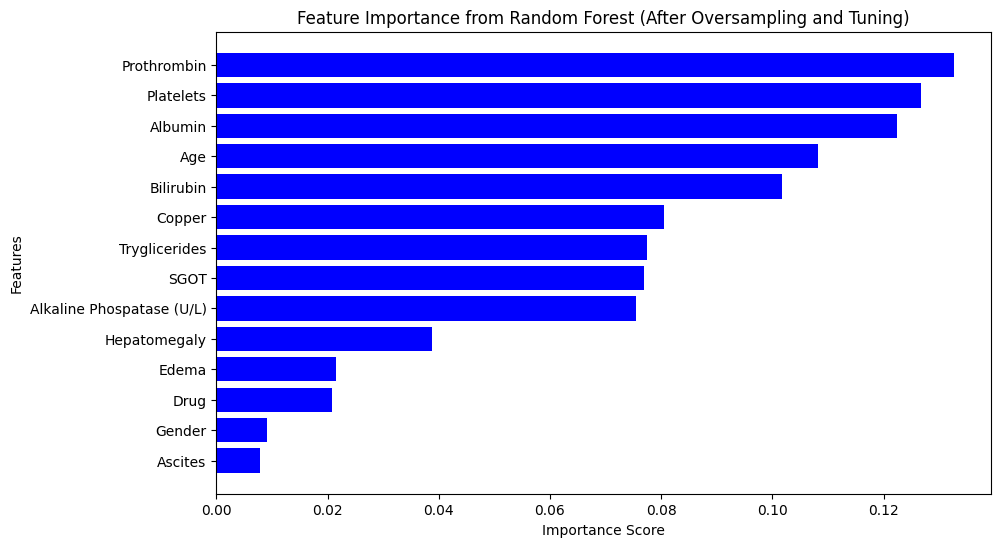

In [45]:
# Extract feature importances
feature_importances = bestestimator_rf.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': xtrain.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print("Top Features:\n", feature_importance_df)

# Visualize the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='blue')
plt.gca().invert_yaxis()  
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance from Random Forest (After Oversampling and Tuning)')
plt.show()

Below are the top 5 of the most importance features in predicting the stage of cirrhosis using Random Forest Classifier model after oversampling and tuning.
1. Prothrombin (13.27%): Prothrombin is one of essential indicator of liver function, specifically related to clotting. Low prothrombin levels could indicate severe liver damage, influencing cirrhosis stage prediction.
2. Platelets (12.67%): Platelet count is often used to assess liver disease severity. In cirrhosis, platelet count tends to be reduced due to the spleen enlarging, so it's a critical marker in predicting liver health.
3. Albumin (12.24%): Albumin plays a crucial role in predicting cirrhosis stages, which makes sense since low albumin levels are commonly associated with liver dysfunction, which may help identify the severity of liver conditions.
4. Age (10.82%): Age is a significant factor in predicting health conditions such as cirrhosis, as the risk of liver disease increases with age. This feature is often predictive of disease progression.
5. Bilirubin (10.16%): Bilirubin levels increase when the liver’s ability to process and excrete waste is impaired, making it an important marker in liver disease. High bilirubin levels may suggest liver dysfunction or cirrhosis.